# Класс для быстрого формирования предобработанного датасета

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from typing import Dict, List, Optional, Union, Tuple
import warnings

class LoanDataPreprocessor:
    """Класс для предобработки данных по кредитам"""

    def __init__(
            self,
            df_path: Optional[str] = None,
            df: Optional[pd.DataFrame] = None,
            age_threshold: int = 122,
            emp_length_threshold: int = 104,
            drop_columns: Optional[List[str]] = None,
            manual_mappings: Optional[Dict] = None,
            target_column: str = 'loan_status',
            exclude_from_features: Optional[List[str]] = None
    ):
        """
        Args:
            df_path: Путь к CSV файлу
            df: Готовый DataFrame (альтернатива df_path)
            age_threshold: Максимальный возраст для фильтрации
            emp_length_threshold: Макс. стаж работы
            drop_columns: Колонки для удаления
            manual_mappings: Ручные маппинги для категориальных признаков
        """
        if df_path and df is not None:
            warnings.warn("Указаны и df_path и df, будет использован df_path")

        self.df_path = df_path
        self.df = df.copy() if df is not None else None
        self.age_threshold = age_threshold
        self.emp_length_threshold = emp_length_threshold
        self.drop_columns = drop_columns or ['loan_int_rate', 'person_age', 'id']
        self.manual_mappings = manual_mappings or {
            'loan_grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6},
            'cb_person_default_on_file': {'N': 0, 'Y': 1}
        }
        self.label_encoders: Dict[str, LabelEncoder] = {}
        self.preprocessing_info: Dict = {}
        self.exclude_from_features = exclude_from_features or []
        self.target_column = target_column
        self.feature_columns: Optional[List[str]] = None

    def load_data(self) -> pd.DataFrame:
        """Загрузка данных из CSV файла"""
        if self.df_path is None:
            raise ValueError("Не указан путь к файлу (df_path)")

        self.df = pd.read_csv(self.df_path)
        return self.df

    def filter_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Фильтрация выбросов по возрасту и стажу"""
        initial_size = len(df)

        # Фильтрация по возрасту
        mask_age = df['person_age'] <= self.age_threshold
        df_filtered = df[mask_age]
        removed_age = initial_size - len(df_filtered)

        # Фильтрация по стажу
        mask_emp = df_filtered['person_emp_length'] <= self.emp_length_threshold
        df_filtered = df_filtered[mask_emp]
        removed_emp = initial_size - removed_age - len(df_filtered)

        self.preprocessing_info['filtering'] = {
            'initial_size': initial_size,
            'final_size': len(df_filtered),
            'removed_age': removed_age,
            'removed_emp': removed_emp,
            'age_threshold': self.age_threshold,
            'emp_threshold': self.emp_length_threshold
        }

        return df_filtered

    def encode_categorical(self, df: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
        """Кодирование категориальных признаков"""
        df_encoded = df.copy()

        # Применяем ручные маппинги
        for col, mapping in self.manual_mappings.items():
            if col in df_encoded.columns:
                df_encoded[col] = df_encoded[col].map(mapping)
                if verbose:
                    print(f"   • {col}: применен ручной маппинг ({len(mapping)} категорий)")

        # Автоматическое кодирование остальных категориальных колонок
        categorical_cols = df_encoded.select_dtypes(include=['object']).columns

        self.label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            self.label_encoders[col] = le

            if verbose:
                print(f"   • {col}: {len(le.classes_)} категорий")

        self.preprocessing_info['encoding'] = {
            'manual_features': list(self.manual_mappings.keys()),
            'auto_features': list(categorical_cols),
            'label_encoders_count': len(self.label_encoders)
        }

        return df_encoded

    def split_features_target(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Разделение данных на признаки (X) и целевую переменную (y)

        Returns:
            Tuple[X, y]
        """
        if self.target_column not in df.columns:
            raise ValueError(f"Целевая колонка '{self.target_column}' не найдена в данных. "
                             f"Доступные колонки: {list(df.columns)}")

        # Определяем колонки для признаков
        all_columns = list(df.columns)
        columns_to_exclude = [self.target_column] + self.exclude_from_features

        feature_columns = [col for col in all_columns if col not in columns_to_exclude]
        self.feature_columns = feature_columns

        X = df[feature_columns]
        y = df[self.target_column]

        self.preprocessing_info['split'] = {
            'feature_columns': feature_columns,
            'target_column': self.target_column,
            'X_shape': X.shape,
            'y_shape': y.shape
        }

        return X, y

    def inverse_transform_categorical(self, df: pd.DataFrame, columns: Optional[List[str]] = None) -> pd.DataFrame:
        """Обратное преобразование категориальных признаков"""
        if not self.label_encoders:
            raise ValueError("LabelEncoders не обучены. Сначала выполните encode_categorical")

        df_inverse = df.copy()
        columns = columns or list(self.label_encoders.keys())

        for col in columns:
            if col in self.label_encoders and col in df_inverse.columns:
                le = self.label_encoders[col]
                # Проверяем, есть ли новые значения
                unique_vals = df_inverse[col].unique()
                if any(val not in le.classes_ for val in unique_vals):
                    warnings.warn(f"В колонке {col} найдены новые значения, пропускаем")
                    continue
                df_inverse[col] = le.inverse_transform(df_inverse[col].astype(int))

        return df_inverse

    def preprocess(
            self,
            verbose: bool = False,
            save_info: bool = True
    ) -> pd.DataFrame:
        """Основной метод предобработки"""
        if self.df is None and self.df_path:
            self.load_data()
        elif self.df is None:
            raise ValueError("Нет данных для обработки")

        df = self.df.copy()

        if verbose:
            print(f"Размер датасета до фильтрации: {len(df)}")

        # Фильтрация
        df = self.filter_outliers(df)

        if verbose:
            print(f"Размер датасета после фильтрации: {len(df)}")
            print(f"Удалено по возрасту: {self.preprocessing_info['filtering']['removed_age']}")
            print(f"Удалено по стажу: {self.preprocessing_info['filtering']['removed_emp']}")

        # Удаление колонок
        cols_to_drop = [col for col in self.drop_columns if col in df.columns]
        if cols_to_drop:
            df = df.drop(columns=cols_to_drop)
            if verbose:
                print(f"Удалены колонки: {cols_to_drop}")

        # Кодирование
        if verbose:
            print("Кодирование категориальных признаков...")
        df = self.encode_categorical(df, verbose=verbose)

        # Сохранение обработанного датафрейма
        self.processed_df = df

        if save_info:
            self.preprocessing_info['final_shape'] = df.shape
            self.preprocessing_info['columns'] = list(df.columns)

        return df

    def get_info(self) -> Dict:
        """Получение информации о проведенной предобработке"""
        return self.preprocessing_info.copy()

    def get_label_encoders(self) -> Dict[str, LabelEncoder]:
        """Получение обученных LabelEncoder"""
        return self.label_encoders.copy()

    def transform_new_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Трансформация новых данных (без переобучения LabelEncoder)"""
        df_transformed = df.copy()

        # Применяем фильтрацию
        df_transformed = df_transformed[
            (df_transformed['person_age'] <= self.age_threshold) &
            (df_transformed['person_emp_length'] <= self.emp_length_threshold)
            ]

        # Удаляем колонки
        cols_to_drop = [col for col in self.drop_columns if col in df_transformed.columns]
        df_transformed = df_transformed.drop(columns=cols_to_drop)

        # Применяем маппинги
        for col, mapping in self.manual_mappings.items():
            if col in df_transformed.columns:
                df_transformed[col] = df_transformed[col].map(mapping)

        # Применяем обученные LabelEncoder
        for col, le in self.label_encoders.items():
            if col in df_transformed.columns:
                # Для новых значений используем -1
                df_transformed[col] = df_transformed[col].apply(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1
                )

        return df_transformed

In [98]:
preprocessor = LoanDataPreprocessor(
    df_path='../../data/train.csv',
    age_threshold=122,
    emp_length_threshold=104,
    drop_columns=['loan_int_rate', 'person_age', 'id']
)

In [99]:
processed_df = preprocessor.preprocess(verbose=True)

Размер датасета до фильтрации: 58645
Размер датасета после фильтрации: 58642
Удалено по возрасту: 1
Удалено по стажу: 2
Удалены колонки: ['loan_int_rate', 'person_age', 'id']
Кодирование категориальных признаков...
   • loan_grade: применен ручной маппинг (7 категорий)
   • cb_person_default_on_file: применен ручной маппинг (2 категорий)
   • person_home_ownership: 4 категорий
   • loan_intent: 6 категорий


In [100]:
info = preprocessor.get_info()
print(f"\nИнформация о предобработке:")
print(f"Итоговый размер: {info['final_shape']}")


Информация о предобработке:
Итоговый размер: (58642, 10)


In [103]:
X, y = preprocessor.split_features_target(processed_df)
X

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,35000,3,0.0,1,1,6000,0.17,0,14
1,56000,2,6.0,3,2,4000,0.07,0,2
2,28800,2,8.0,4,0,6000,0.21,0,10
3,70000,3,14.0,5,1,12000,0.17,0,5
4,60000,3,2.0,3,0,6000,0.10,0,3
...,...,...,...,...,...,...,...,...,...
58640,120000,0,5.0,1,3,25000,0.21,1,10
58641,28800,3,0.0,3,2,10000,0.35,0,8
58642,44000,3,7.0,1,3,6800,0.15,0,2
58643,30000,3,2.0,1,0,5000,0.17,0,3


In [104]:
y

0        0
1        0
2        0
3        0
4        0
        ..
58640    0
58641    1
58642    1
58643    0
58644    0
Name: loan_status, Length: 58642, dtype: int64

# Базовый класс модели

In [2]:
from abc import ABC, abstractmethod
from typing import Dict, List, Optional, Union, Any
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


def get_scoring() -> Dict[str, Any]:
    """Получить словарь с метриками для оценки"""
    from sklearn.metrics import make_scorer

    return {
        'precision': make_scorer(precision_score, average='binary', pos_label=1),
        'recall': make_scorer(recall_score, average='binary', pos_label=1),
        'f1': make_scorer(f1_score, average='binary', pos_label=1),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
        'average_precision': make_scorer(average_precision_score, needs_proba=True)
    }


class BaseModel(ABC):
    """Абстрактный базовый класс для всех моделей"""

    def __init__(self, random_state: int = 42, test_size: float = 0.2):
        self.random_state = random_state
        self.test_size = test_size
        self.model = None
        self.best_params_ = None
        self.best_score_ = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    @abstractmethod
    def create_pipeline(self) -> Pipeline:
        """Создать pipeline модели"""
        pass

    @abstractmethod
    def get_param_grid(self) -> List[Dict]:
        """Получить сетку параметров для GridSearch"""
        pass

    def split_data(self, X: np.ndarray, y: np.ndarray) -> None:
        """Разделить данные на train/test"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )

    def train(self, X: np.ndarray, y: np.ndarray, cv: int = 3,
              scoring: str = 'roc_auc', n_jobs: int = -1) -> None:
        """
        Обучение модели с GridSearchCV

        Args:
            X: Признаки
            y: Целевая переменная
            cv: Количество фолдов
            scoring: Метрика для оптимизации
            n_jobs: Количество ядер для параллельных вычислений
        """
        self.split_data(X, y)

        pipeline = self.create_pipeline()
        param_grid = self.get_param_grid()

        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)

        gs = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=skf,
            scoring=scoring,
            n_jobs=n_jobs
        )

        gs.fit(self.X_train, self.y_train)

        self.model = gs.best_estimator_
        self.best_params_ = gs.best_params_
        self.best_score_ = gs.best_score_

        print(f'Лучшие параметры: {self.best_params_}')
        print(f'Лучшее качество на кросс-валидации: {self.best_score_:.4f}')

    def evaluate(self, cv: int = 3, n_jobs: int = -1) -> Dict[str, Any]:
        """
        Оценка модели на тестовых данных

        Returns:
            Словарь с метриками
        """
        from sklearn.model_selection import cross_val_predict

        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод train()")

        # Предсказания на тестовых данных
        y_pred = cross_val_predict(
            self.model, self.X_test, self.y_test,
            cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state),
            n_jobs=n_jobs
        )

        # Отчет
        report = classification_report(self.y_test, y_pred)

        # Матрица ошибок
        cm = confusion_matrix(self.y_test, y_pred)

        # Визуализация матрицы ошибок
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'y_pred': y_pred
        }

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Предсказание на новых данных"""
        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод train()")
        return self.model.predict(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Предсказание вероятностей на новых данных"""
        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод train()")
        return self.model.predict_proba(X)

# Логистическая регрессия

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(BaseModel):
    """Модель логистической регрессии"""

    def __init__(self, random_state: int = 42, test_size: float = 0.2,
                 class_weight_options: List = None):
        super().__init__(random_state, test_size)
        self.class_weight_options = class_weight_options or ['balanced', None]

    def create_pipeline(self) -> Pipeline:
        return make_pipeline(
            StandardScaler(),
            LogisticRegression(
                random_state=self.random_state,
                n_jobs=-1,
                max_iter=1000
            )
        )

    def get_param_grid(self) -> List[Dict]:
        return [
            {
                'logisticregression__penalty': ['l1'],
                'logisticregression__C': np.linspace(0.1, 100, 10),
                'logisticregression__solver': ['saga'],
                'logisticregression__class_weight': self.class_weight_options
            },
            {
                'logisticregression__penalty': ['l2'],
                'logisticregression__C': np.linspace(0.1, 100, 10),
                'logisticregression__solver': ['lbfgs', 'saga'],
                'logisticregression__class_weight': self.class_weight_options
            },
            {
                'logisticregression__penalty': ['elasticnet'],
                'logisticregression__C': np.linspace(0.1, 100, 10),
                'logisticregression__l1_ratio': np.linspace(0, 1, 10),
                'logisticregression__solver': ['saga'],
                'logisticregression__class_weight': self.class_weight_options
            },
            {
                'logisticregression__penalty': [None],
                'logisticregression__solver': ['lbfgs', 'newton-cg', 'saga'],
                'logisticregression__class_weight': self.class_weight_options
            }
        ]

    def plot_threshold_analysis(self, cv: int = 3, n_jobs: int = -1) -> Dict[str, List]:
        """
        Анализ зависимости метрик от порога вероятности

        Returns:
            Словарь с метриками для разных порогов
        """
        from sklearn.model_selection import cross_val_predict

        y_proba_pred = cross_val_predict(
            self.model, self.X_test, self.y_test,
            cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state),
            method='predict_proba', n_jobs=n_jobs
        )[:, 1]

        y_proba_pred = pd.Series(y_proba_pred)

        thresholds = np.arange(0.1, 1, 0.05)
        recall_scores = []
        precision_scores = []
        f1_scores = []

        for threshold in thresholds:
            y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
            recall_scores.append(recall_score(self.y_test, y_pred))
            precision_scores.append(precision_score(self.y_test, y_pred))
            f1_scores.append(f1_score(self.y_test, y_pred))

        plt.figure(figsize=(12, 6))
        plt.plot(thresholds, recall_scores, label='Recall', marker='o')
        plt.plot(thresholds, precision_scores, label='Precision', marker='s')
        plt.plot(thresholds, f1_scores, label='F1-score', marker='^')

        plt.title('Зависимость метрик от порога вероятности')
        plt.xlabel('Порог вероятности')
        plt.ylabel('Метрика')
        plt.xticks(thresholds, rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        return {
            'thresholds': thresholds,
            'recall': recall_scores,
            'precision': precision_scores,
            'f1': f1_scores
        }

## Обучение бейзлайн модели логистической регрессии

In [4]:
lr_preprocessor = LoanDataPreprocessor(
    df_path='../../data/train.csv',
    age_threshold=122,
    emp_length_threshold=104,
    drop_columns=['loan_int_rate', 'person_age', 'id']
)

In [5]:
lr_processed_df = lr_preprocessor.preprocess(verbose=True)

Размер датасета до фильтрации: 58645
Размер датасета после фильтрации: 58642
Удалено по возрасту: 1
Удалено по стажу: 2
Удалены колонки: ['loan_int_rate', 'person_age', 'id']
Кодирование категориальных признаков...
   • loan_grade: применен ручной маппинг (7 категорий)
   • cb_person_default_on_file: применен ручной маппинг (2 категорий)
   • person_home_ownership: 4 категорий
   • loan_intent: 6 категорий


In [6]:
X, y = lr_preprocessor.split_features_target(lr_processed_df)

In [7]:
lr_model = LogisticRegressionModel()
lr_model.train(X, y)

Лучшие параметры: {'logisticregression__C': np.float64(0.1), 'logisticregression__class_weight': 'balanced', 'logisticregression__l1_ratio': np.float64(0.7777777777777777), 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
Лучшее качество на кросс-валидации: 0.8814


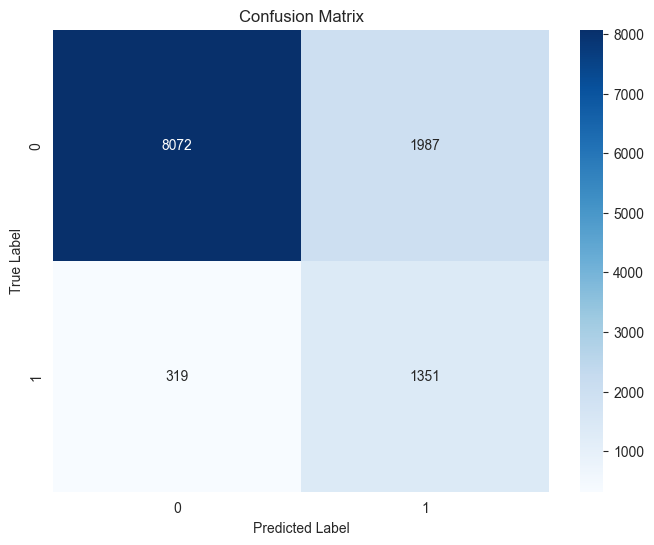

In [9]:
lr_eval = lr_model.evaluate()

In [10]:
print(lr_eval['classification_report'])

              precision    recall  f1-score   support

           0       0.96      0.80      0.88     10059
           1       0.40      0.81      0.54      1670

    accuracy                           0.80     11729
   macro avg       0.68      0.81      0.71     11729
weighted avg       0.88      0.80      0.83     11729



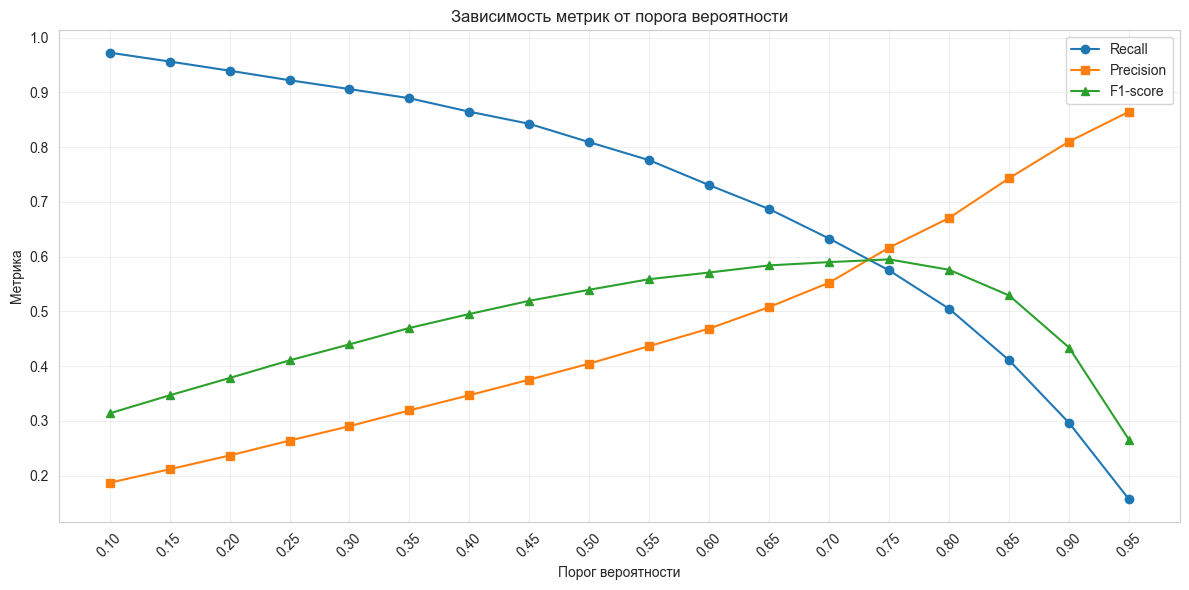

{'thresholds': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
        0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'recall': [0.9724550898203593,
  0.9562874251497006,
  0.9395209580838323,
  0.9221556886227545,
  0.9059880239520958,
  0.8892215568862275,
  0.8646706586826347,
  0.8425149700598802,
  0.8089820359281437,
  0.7760479041916167,
  0.7305389221556886,
  0.6868263473053893,
  0.6329341317365269,
  0.5748502994011976,
  0.5047904191616767,
  0.41077844311377243,
  0.2964071856287425,
  0.1568862275449102],
 'precision': [0.1871398939847891,
  0.21174754706974278,
  0.2368659420289855,
  0.26410564225690275,
  0.2904030710172745,
  0.3192175408426483,
  0.3470319634703196,
  0.37540021344717184,
  0.4047333732774116,
  0.4366576819407008,
  0.46868997310795235,
  0.5079716563330381,
  0.5525352848928384,
  0.6165703275529865,
  0.6706443914081146,
  0.7432286023835319,
  0.8101472995090017,
  0.8646864686468647],
 'f1': [0.3138770776961732,
  0.346721

In [14]:
lr_model.plot_threshold_analysis()

# Базовый класс для ансамблевых моделей

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

class EnsembleModel(BaseModel):
    """Абстрактный класс для ансамблевых моделей"""

    def __init__(self, random_state: int = 42, test_size: float = 0.2):
        super().__init__(random_state, test_size)

    @abstractmethod
    def get_ensemble_models(self) -> Dict[str, BaseEstimator]:
        """Получить словарь базовых моделей для ансамбля"""
        pass

    def plot_feature_importance(self, feature_names: List[str] = None) -> None:
        """
        Визуализация важности признаков для Decision Tree

        Args:
            feature_names: Список названий признаков
        """
        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод train()")

        feature = self.X_train.columns
        feature_importances = self.model.named_steps['classifier'].feature_importances_
        plt.figure(figsize=(15, 7))

        sns.barplot(x=feature, y=feature_importances)

        plt.title('Важность признаков')
        plt.xlabel('Признаки')
        plt.ylabel('Важность')
        plt.xticks(rotation=90)

        # plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
        plt.show()

        return feature_importances

# Модель решающего дерева

In [13]:
from sklearn.tree import DecisionTreeClassifier


class DecisionTreeModel(BaseModel):

    def __init__(self, random_state: int = 42, test_size: float = 0.2,
                 class_weight_options: List = None,
                 max_depth_range: List = None,
                 min_samples_split_range: List = None,
                 min_samples_leaf_range: List = None,
                 criterion_options: List = None):
        super().__init__(random_state, test_size)

        self.class_weight_options = class_weight_options or ['balanced', None]
        self.max_depth_range = max_depth_range or [None, 5, 10, 15, 20, 30]
        self.min_samples_split_range = min_samples_split_range or [2, 5, 10, 20]
        self.min_samples_leaf_range = min_samples_leaf_range or [1, 2, 4, 8]
        self.criterion_options = criterion_options or ['gini', 'entropy']

    def create_pipeline(self) -> Pipeline:
        return Pipeline([
            ('classifier', DecisionTreeClassifier(random_state=self.random_state))
        ])

    def get_param_grid(self) -> List[Dict]:
        return [{
            'classifier__max_depth': range(1, 4),
            'classifier__min_samples_split': [2, 5, 10, 15, 20],
            'classifier__min_samples_leaf': [1, 3, 5, 10, 15],
            'classifier__max_features': [None, 'sqrt', 'log2', 0.3, 0.5],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__class_weight': [None, 'balanced']
        }]


    def plot_tree_structure(self, max_depth: int = 3, feature_names: List[str] = None) -> None:
        """
        Визуализация структуры дерева (только для небольших деревьев)

        Args:
            max_depth: Максимальная глубина для визуализации
            feature_names: Список названий признаков
        """
        from sklearn import tree

        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод train()")

        tree_model = self.model.named_steps['classifier']

        plt.figure(figsize=(15, 10))
        tree.plot_tree(
            tree_model,
            feature_names=self.X_train.columns,
            class_names=["0 - не одобрено", "1 - одобрено"],
            filled=True,
        )

        # plt.figure(figsize=(20, 10))
        # plot_tree(
        #     tree_model,
        #     filled=True,
        #     rounded=True,
        #     max_depth=max_depth,
        #     feature_names=feature_names,
        #     class_names=['Class 0', 'Class 1'] if len(set(self.y_train)) == 2 else None,
        #     fontsize=10
        # )
        # plt.title(f'Decision Tree (глубина {max_depth})')
        # plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, feature_names: List[str] = None) -> None:
        """
        Визуализация важности признаков для Decision Tree

        Args:
            feature_names: Список названий признаков
        """
        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод train()")

        feature = self.X_train.columns
        feature_importances = self.model.named_steps['classifier'].feature_importances_
        plt.figure(figsize=(15, 7))

        sns.barplot(x=feature, y=feature_importances)

        plt.title('Важность признаков')
        plt.xlabel('Признаки')
        plt.ylabel('Важность')
        plt.xticks(rotation=90)

        # plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
        plt.show()

        return feature_importances

## Обучение модели решающего дерева

In [15]:
dt_preprocessor = LoanDataPreprocessor(
    df_path='../../data/train.csv',
    age_threshold=122,
    emp_length_threshold=104,
    drop_columns=['loan_int_rate', 'person_age', 'id']
)

In [16]:
dt_processed_df = dt_preprocessor.preprocess(verbose=True)

Размер датасета до фильтрации: 58645
Размер датасета после фильтрации: 58642
Удалено по возрасту: 1
Удалено по стажу: 2
Удалены колонки: ['loan_int_rate', 'person_age', 'id']
Кодирование категориальных признаков...
   • loan_grade: применен ручной маппинг (7 категорий)
   • cb_person_default_on_file: применен ручной маппинг (2 категорий)
   • person_home_ownership: 4 категорий
   • loan_intent: 6 категорий


In [17]:
X, y = dt_preprocessor.split_features_target(dt_processed_df)

In [18]:
dt_model = DecisionTreeModel()
dt_model.train(X, y)

Лучшие параметры: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Лучшее качество на кросс-валидации: 0.8824


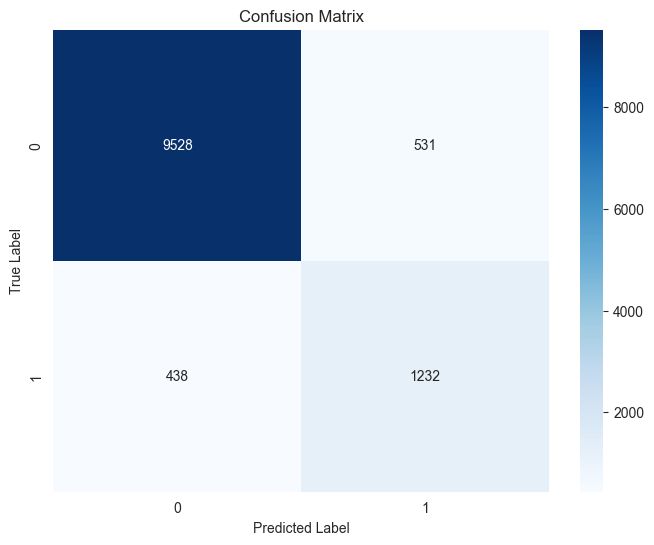

In [19]:
dt_model_eval = dt_model.evaluate()

In [20]:
print(dt_model_eval['classification_report'])

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     10059
           1       0.70      0.74      0.72      1670

    accuracy                           0.92     11729
   macro avg       0.83      0.84      0.83     11729
weighted avg       0.92      0.92      0.92     11729



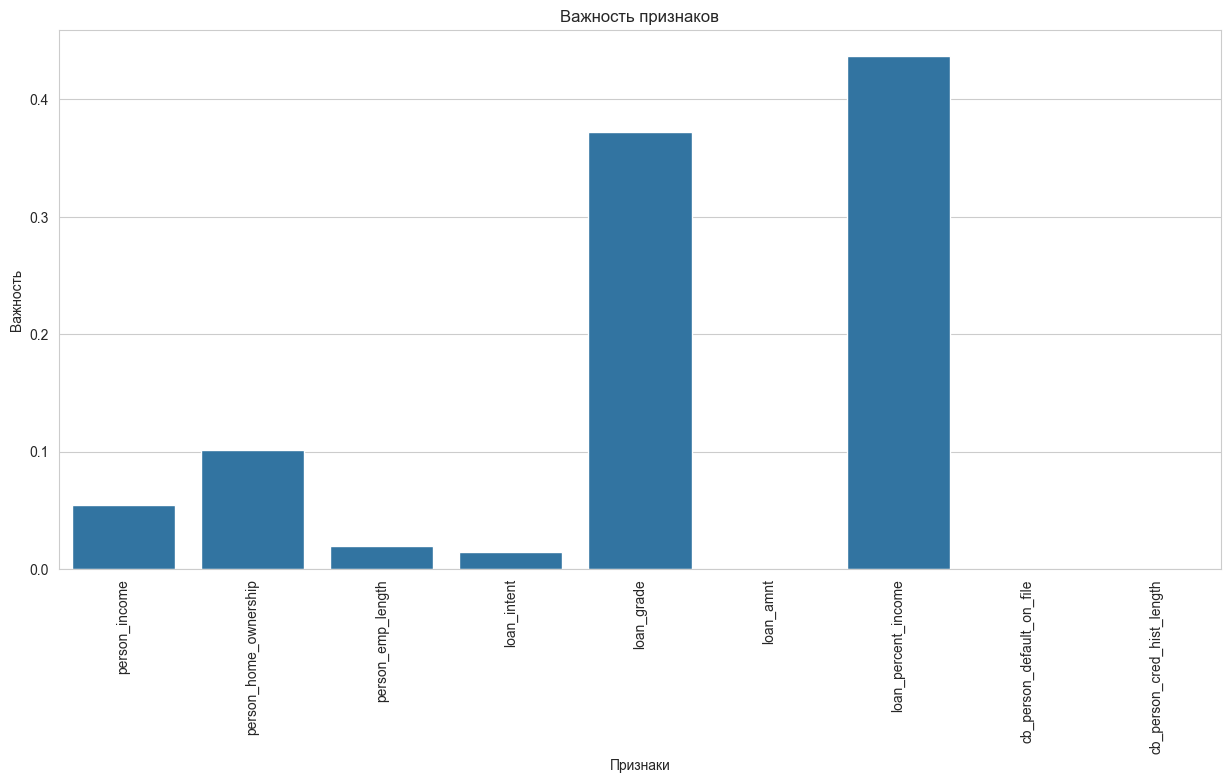

In [24]:
fi = dt_model.plot_feature_importance()

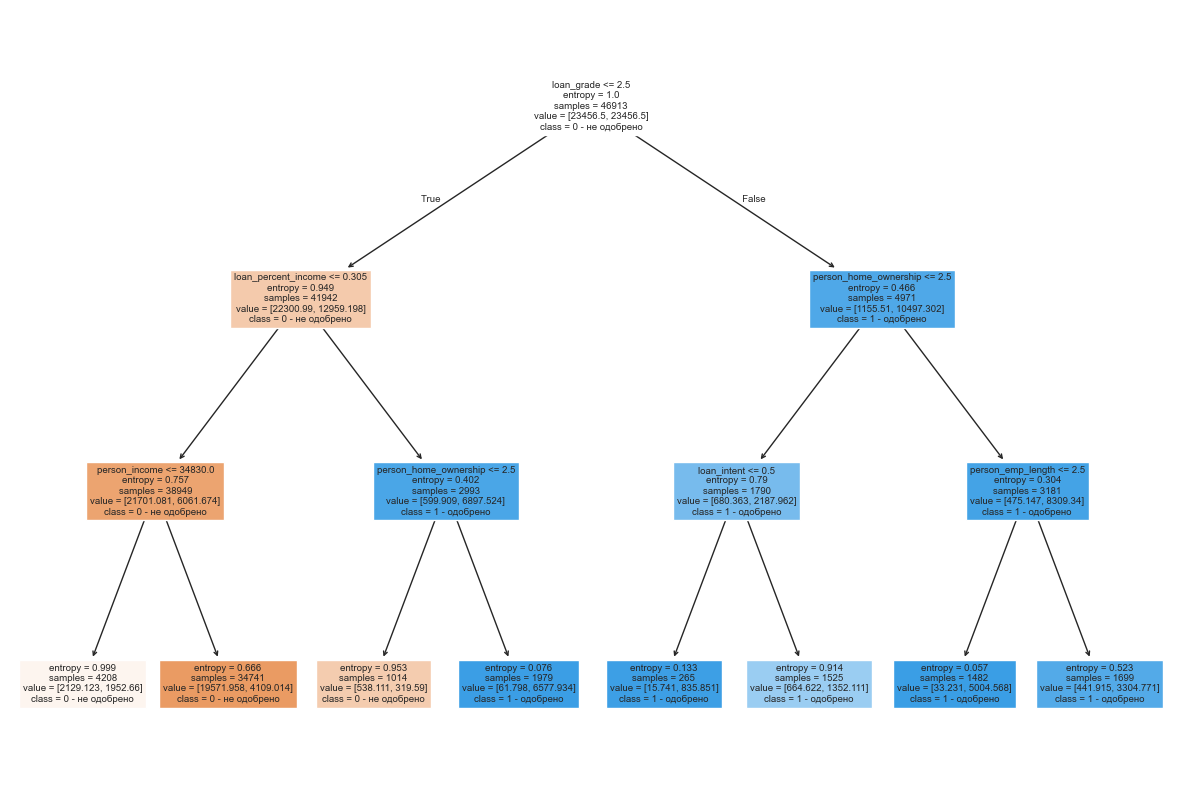

In [22]:
dt_model.plot_tree_structure()

## Обучение модели с отсеченными по важности признаками

In [26]:
# Отбор признаков по важности
selected_features = X.columns[fi > 0]

# Создание новых наборов данных с отобранными признаками
X_train_selected = X[selected_features]
X_test_selected = X[selected_features]
X_train_selected

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_percent_income
0,35000,3,0.0,1,1,0.17
1,56000,2,6.0,3,2,0.07
2,28800,2,8.0,4,0,0.21
3,70000,3,14.0,5,1,0.17
4,60000,3,2.0,3,0,0.10
...,...,...,...,...,...,...
58640,120000,0,5.0,1,3,0.21
58641,28800,3,0.0,3,2,0.35
58642,44000,3,7.0,1,3,0.15
58643,30000,3,2.0,1,0,0.17


In [27]:
dt_model.train(X_train_selected, y)

Лучшие параметры: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Лучшее качество на кросс-валидации: 0.8824


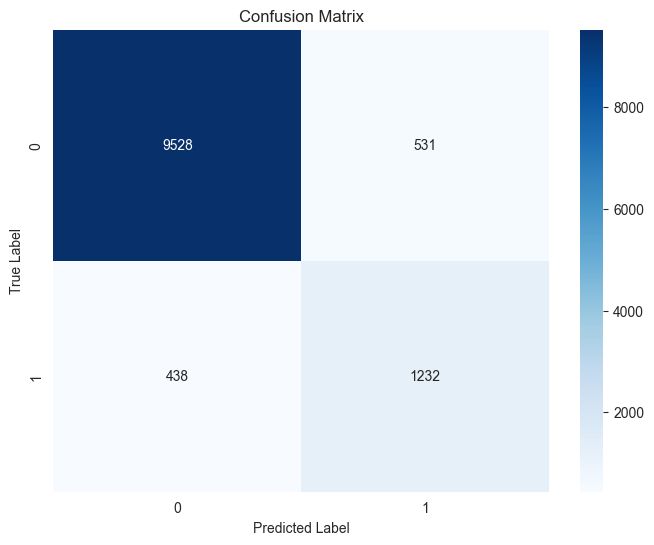

In [28]:
dt_model_eval = dt_model.evaluate()

In [29]:
print(dt_model_eval['classification_report'])

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     10059
           1       0.70      0.74      0.72      1670

    accuracy                           0.92     11729
   macro avg       0.83      0.84      0.83     11729
weighted avg       0.92      0.92      0.92     11729



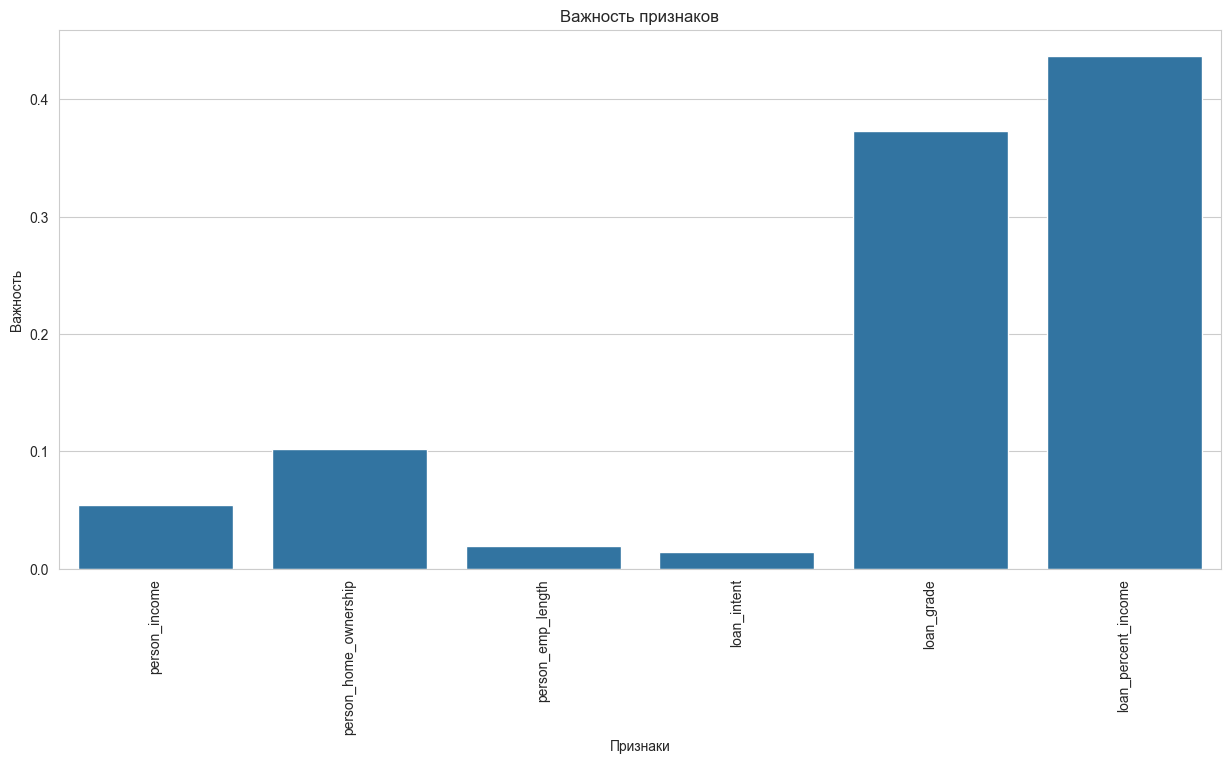

array([0.0547499 , 0.10183085, 0.01933871, 0.01437196, 0.37253988,
       0.43716869])

In [30]:
dt_model.plot_feature_importance()

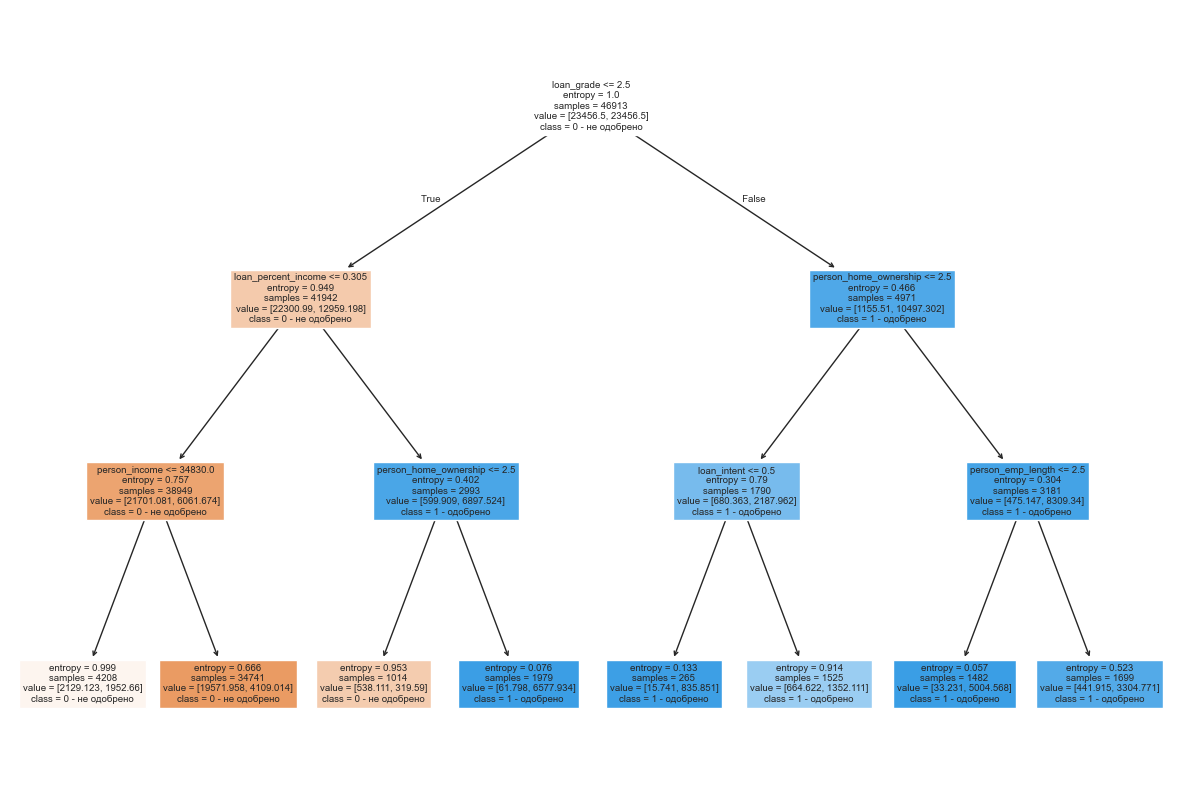

In [31]:
dt_model.plot_tree_structure()

# XGBoost модель

In [32]:
class XGBoostModel(EnsembleModel):

    def create_pipeline(self) -> Pipeline:
        return Pipeline([
            ('classifier', XGBClassifier(random_state=self.random_state, use_label_encoder=False, eval_metric='logloss'))
        ])

    def get_param_grid(self) -> List[Dict]:
        return [{
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.3],
            'classifier__subsample': [0.8, 0.9, 1.0],
            'classifier__colsample_bytree': [0.8, 0.9, 1.0]
        }]

    def get_ensemble_models(self) -> Dict[str, BaseEstimator]:
        return {
            'xgb': XGBClassifier(random_state=self.random_state, use_label_encoder=False, eval_metric='logloss')
        }

## Обучение XGBoost модели

In [33]:
xgb_preprocessor = LoanDataPreprocessor(
    df_path='../../data/train.csv',
    age_threshold=122,
    emp_length_threshold=104,
    drop_columns=['loan_int_rate', 'person_age', 'id']
)

In [34]:
xgb_df = xgb_preprocessor.preprocess(verbose=True)

Размер датасета до фильтрации: 58645
Размер датасета после фильтрации: 58642
Удалено по возрасту: 1
Удалено по стажу: 2
Удалены колонки: ['loan_int_rate', 'person_age', 'id']
Кодирование категориальных признаков...
   • loan_grade: применен ручной маппинг (7 категорий)
   • cb_person_default_on_file: применен ручной маппинг (2 категорий)
   • person_home_ownership: 4 категорий
   • loan_intent: 6 категорий


In [35]:
X, y = xgb_preprocessor.split_features_target(xgb_df)

In [36]:
xgboost_model = XGBoostModel()
xgboost_model.train(X, y, scoring='roc_auc')

C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:27:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Лучшие параметры: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}
Лучшее качество на кросс-валидации: 0.9530


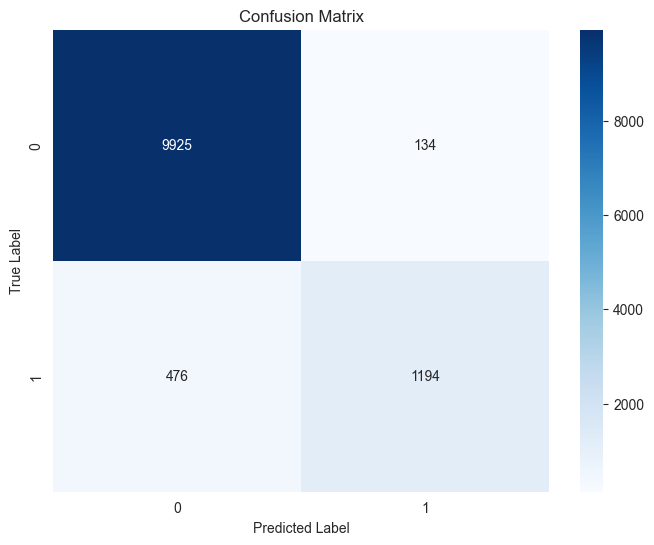

In [37]:
xgboost_model_eval = xgboost_model.evaluate()

In [38]:
print(xgboost_model_eval['classification_report'])

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.90      0.71      0.80      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.85      0.88     11729
weighted avg       0.95      0.95      0.95     11729



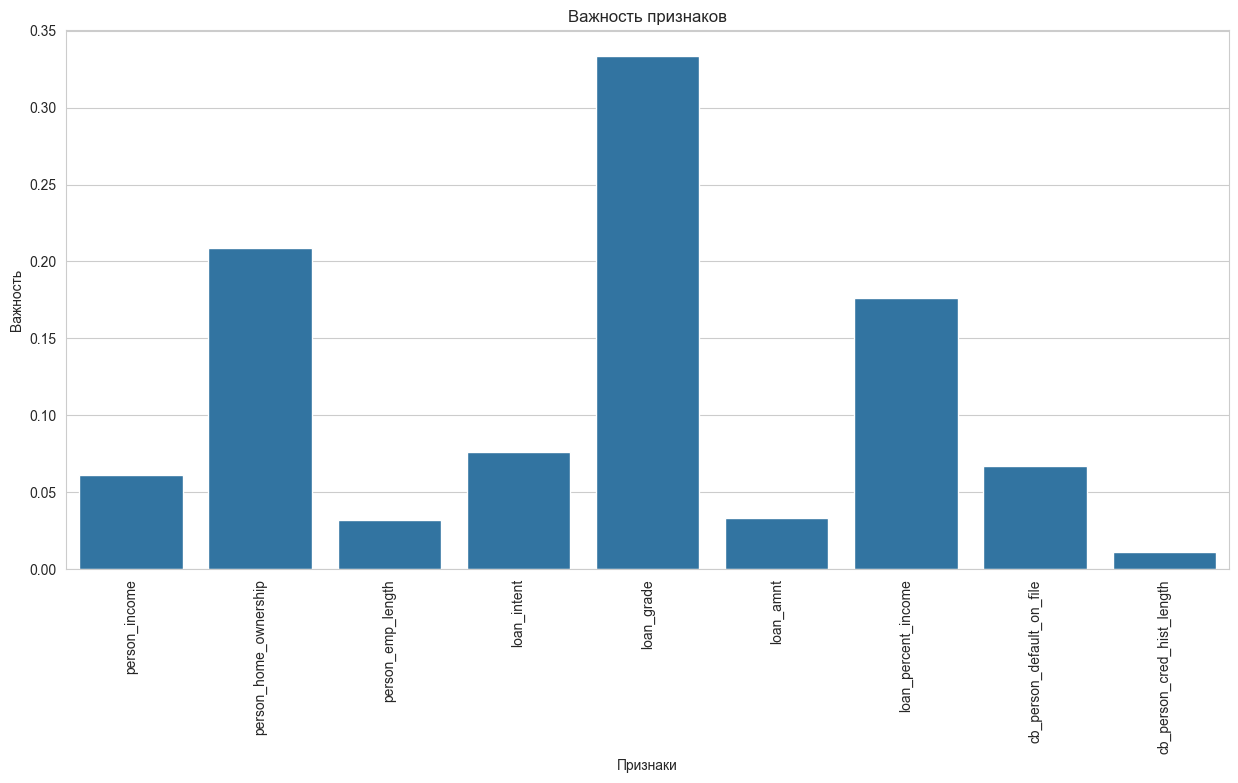

array([0.06132898, 0.20861563, 0.03194526, 0.07622247, 0.33369777,
       0.03336465, 0.1762454 , 0.06727201, 0.01130776], dtype=float32)

In [39]:
xgboost_model.plot_feature_importance()

# RandomForest модель

In [40]:
class RandomForestModel(EnsembleModel):
    def create_pipeline(self) -> Pipeline:
        return Pipeline([
            ('classifier', RandomForestClassifier(random_state=self.random_state))
        ])

    def get_param_grid(self) -> List[Dict]:
        return [{
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': range(1, 11),
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__class_weight': ['balanced', None]
        }]

    def get_ensemble_models(self) -> Dict[str, BaseEstimator]:
        return {
            'rf': RandomForestClassifier(random_state=self.random_state)
        }



## Обучение модели Random Forest

In [41]:
rf_preprocessor = LoanDataPreprocessor(
    df_path='../../data/train.csv',
    age_threshold=122,
    emp_length_threshold=104,
    drop_columns=['loan_int_rate', 'person_age', 'id']
)

In [42]:
rf_df = rf_preprocessor.preprocess(verbose=True)
X, y = rf_preprocessor.split_features_target(rf_df)

Размер датасета до фильтрации: 58645
Размер датасета после фильтрации: 58642
Удалено по возрасту: 1
Удалено по стажу: 2
Удалены колонки: ['loan_int_rate', 'person_age', 'id']
Кодирование категориальных признаков...
   • loan_grade: применен ручной маппинг (7 категорий)
   • cb_person_default_on_file: применен ручной маппинг (2 категорий)
   • person_home_ownership: 4 категорий
   • loan_intent: 6 категорий


In [43]:
rf_model = RandomForestModel()

In [44]:
rf_model.train(X, y)

Лучшие параметры: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Лучшее качество на кросс-валидации: 0.9344


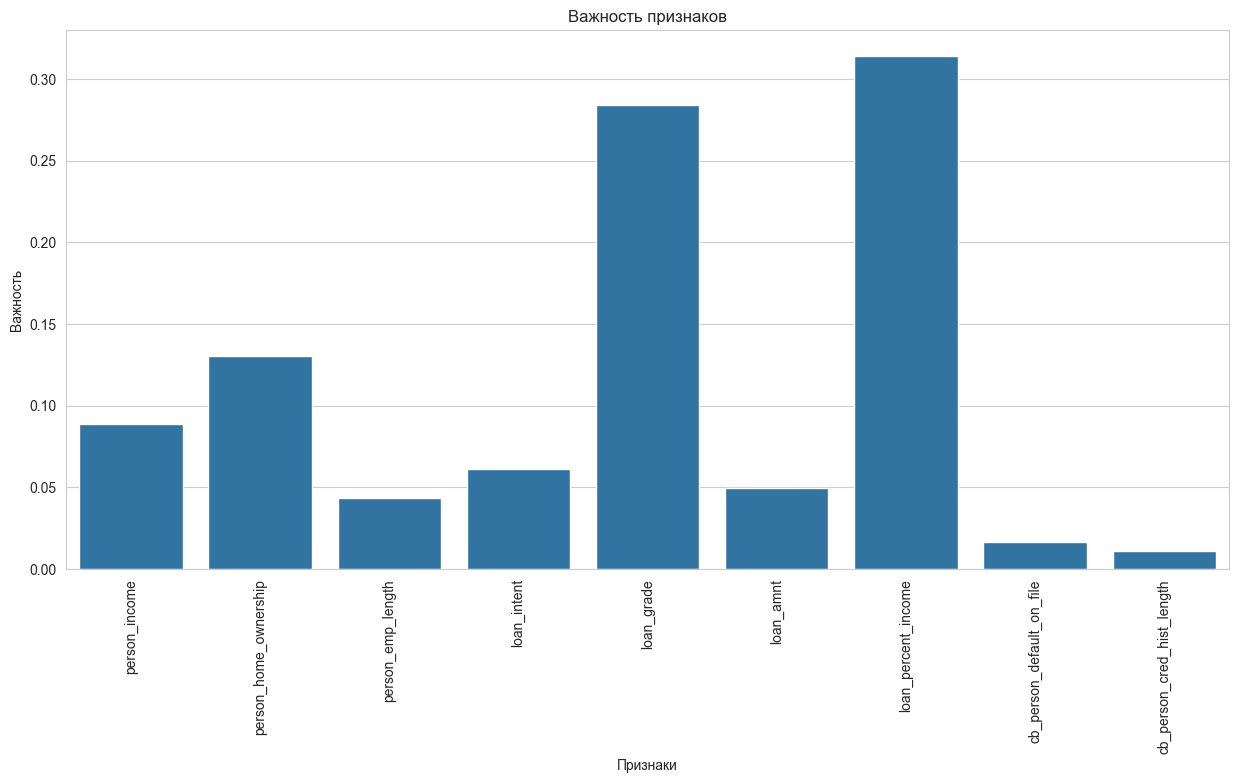

array([0.08907169, 0.13050028, 0.0435727 , 0.06101786, 0.28385013,
       0.04991107, 0.31425404, 0.01653689, 0.01128536])

In [45]:
rf_model.plot_feature_importance()

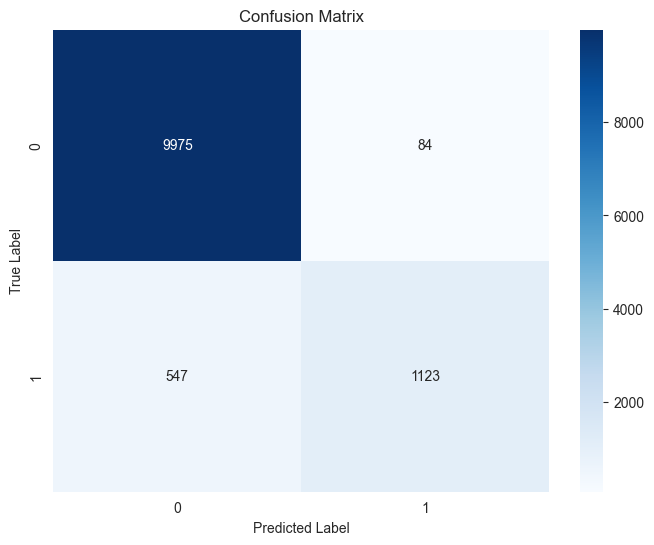

In [46]:
rf_eval = rf_model.evaluate()

In [47]:
print(rf_eval['classification_report'])

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.93      0.67      0.78      1670

    accuracy                           0.95     11729
   macro avg       0.94      0.83      0.88     11729
weighted avg       0.95      0.95      0.94     11729



# LightGBM

In [54]:
from lightgbm import LGBMClassifier

class LightGBMModel(EnsembleModel):
    def create_pipeline(self) -> Pipeline:
        return Pipeline([
            ('classifier', LGBMClassifier(random_state=self.random_state))
        ])

    def get_param_grid(self) -> List[Dict]:
        return [{
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': range(1, 11),
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__class_weight': ['balanced', None]
        }]

    def get_ensemble_models(self) -> Dict[str, BaseEstimator]:
        return {
            'lgbm': LGBMClassifier(random_state=self.random_state)
        }



## Обучение LightGBM модели

In [48]:
lgbm_preprocessor = LoanDataPreprocessor(
    df_path='../../data/train.csv',
    age_threshold=122,
    emp_length_threshold=104,
    drop_columns=['loan_int_rate', 'person_age', 'id']
)

In [49]:
lgbm_df = lgbm_preprocessor.preprocess(verbose=True)

Размер датасета до фильтрации: 58645
Размер датасета после фильтрации: 58642
Удалено по возрасту: 1
Удалено по стажу: 2
Удалены колонки: ['loan_int_rate', 'person_age', 'id']
Кодирование категориальных признаков...
   • loan_grade: применен ручной маппинг (7 категорий)
   • cb_person_default_on_file: применен ручной маппинг (2 категорий)
   • person_home_ownership: 4 категорий
   • loan_intent: 6 категорий


In [50]:
X, y = lgbm_preprocessor.split_features_target(lgbm_df)

In [55]:
lgbm_model = LightGBMModel()
lgbm_model.train(X, y)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 6679, number of negative: 40234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 46913, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142370 -> initscore=-1.795744
[LightGBM] [Info] Start training from score -1.795744
[LightGBM] [Warning] No further s

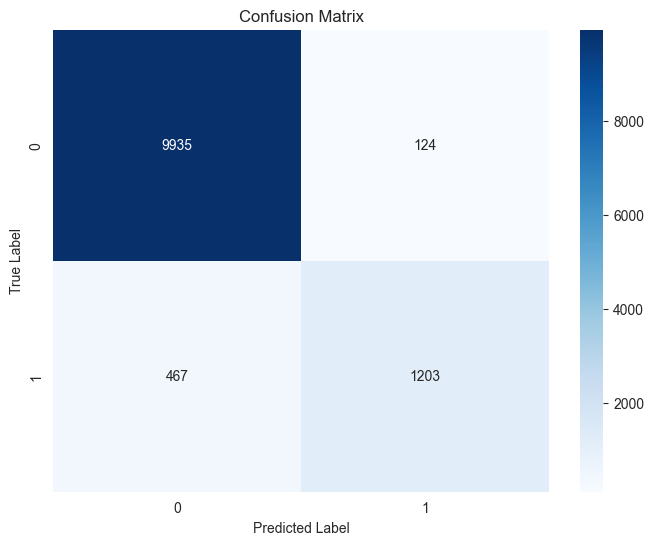

In [56]:
lgbm_model_eval = lgbm_model.evaluate()

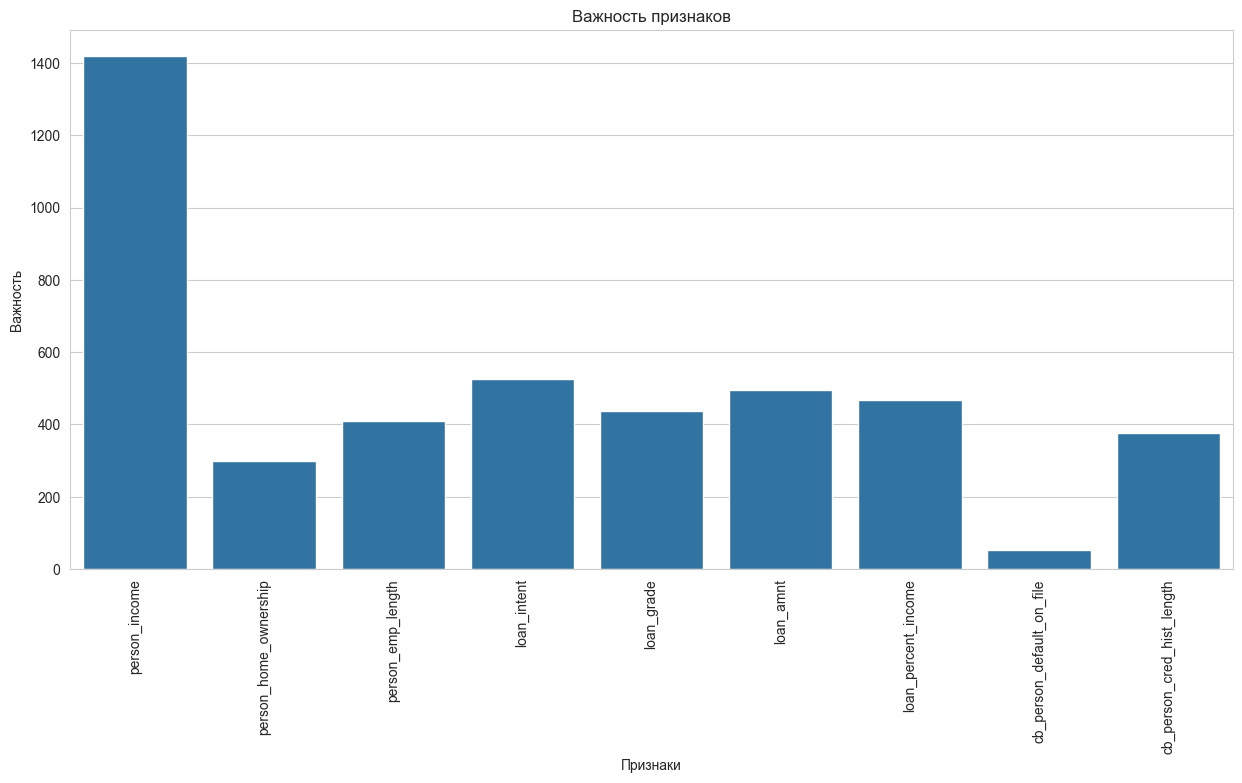

array([1420,  298,  409,  525,  436,  496,  467,   52,  376], dtype=int32)

In [57]:
lgbm_model.plot_feature_importance()

In [58]:
print(lgbm_model_eval['classification_report'])

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.91      0.72      0.80      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729



# CatBoost

In [62]:
from catboost import CatBoostClassifier

class CatBoostModel(EnsembleModel):
    def create_pipeline(self) -> Pipeline:
        return Pipeline([
            ('classifier', CatBoostClassifier(random_state=self.random_state))
        ])

    def get_param_grid(self) -> List[Dict]:
        return [{
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': range(1, 5),
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__class_weight': ['balanced', None]
        }]

    def get_ensemble_models(self) -> Dict[str, BaseEstimator]:
        return {
            'cb': CatBoostClassifier(random_state=self.random_state)
        }

In [59]:
cb_preprocessor = LoanDataPreprocessor(
    df_path='../../data/train.csv',
    age_threshold=122,
    emp_length_threshold=104,
    drop_columns=['loan_int_rate', 'person_age', 'id']
)

In [60]:
cb_df = cb_preprocessor.preprocess(verbose=True)
X, y = cb_preprocessor.split_features_target(cb_df)

Размер датасета до фильтрации: 58645
Размер датасета после фильтрации: 58642
Удалено по возрасту: 1
Удалено по стажу: 2
Удалены колонки: ['loan_int_rate', 'person_age', 'id']
Кодирование категориальных признаков...
   • loan_grade: применен ручной маппинг (7 категорий)
   • cb_person_default_on_file: применен ручной маппинг (2 категорий)
   • person_home_ownership: 4 категорий
   • loan_intent: 6 категорий


In [63]:
cb_model = CatBoostModel()
cb_model.train(X, y)

ValueError: 
All the 648 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 2321, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6601, in _catboost._check_train_params
  File "_catboost.pyx", line 6623, in _catboost._check_train_params
_catboost.CatBoostError: catboost/private/libs/options/plain_options_helper.cpp:512: Unknown option {min_samples_leaf} with value "1"

--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 2321, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6601, in _catboost._check_train_params
  File "_catboost.pyx", line 6623, in _catboost._check_train_params
_catboost.CatBoostError: catboost/private/libs/options/plain_options_helper.cpp:512: Unknown option {min_samples_leaf} with value "2"

--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\magistratura\loan-approval-prediction\.venv\Lib\site-packages\catboost\core.py", line 2321, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6601, in _catboost._check_train_params
  File "_catboost.pyx", line 6623, in _catboost._check_train_params
_catboost.CatBoostError: catboost/private/libs/options/plain_options_helper.cpp:512: Unknown option {min_samples_leaf} with value "4"


In [ ]:
class VotingEnsembleModel(EnsembleModel):

    def __init__(self, random_state: int = 42, test_size: float = 0.2):
        super().__init__(random_state, test_size)
        self.base_models = []

    def add_model(self, model: BaseModel) -> None:
        self.base_models.append(model)

    def create_pipeline(self) -> Pipeline:
        estimators = []
        for i, base_model in enumerate(self.base_models):
            estimators.append((f'model_{i}', base_model.create_pipeline()))

        return Pipeline([
            ('voting', VotingClassifier(
                estimators=estimators,
                voting='soft',
                n_jobs=-1
            ))
        ])

    def get_param_grid(self) -> List[Dict]:
        return [{
            'voting__weights': [
                [1, 1, 1],
                [2, 1, 1],
                [1, 2, 1],
                [1, 1, 2]
            ]
        }]

    def get_ensemble_models(self) -> Dict[str, BaseEstimator]:
        models = {}
        for i, base_model in enumerate(self.base_models):
            models[f'model_{i}'] = base_model.create_pipeline()
        return models

# Класс визуализации

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, roc_auc_score, mean_squared_error,
    mean_absolute_error, r2_score, explained_variance_score
)
from sklearn.calibration import calibration_curve
import scikitplot as skplt
from typing import Optional, Union, List, Dict, Tuple, Any
import warnings
import json
import os

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


class ModelResultsVisualizer:
    """
    Класс для визуализации и анализа результатов работы ML моделей.
    Поддерживает как классификацию, так и регрессию.
    """

    def __init__(
            self,
            model_name: str = "Model",
            task_type: str = "classification",  # "classification" или "regression"
            target_names: Optional[List[str]] = None,
            figsize: Tuple[int, int] = (10, 8),
            output_dir: str = "model_results",
            save_plots: bool = True
    ):
        """
        Args:
            model_name: Название модели (для заголовков графиков)
            task_type: Тип задачи: "classification" или "regression"
            target_names: Названия классов (для классификации)
            figsize: Размер графиков по умолчанию
            output_dir: Директория для сохранения графиков
            save_plots: Сохранять ли графики в файлы
        """
        self.model_name = model_name
        self.task_type = task_type
        self.target_names = target_names
        self.figsize = figsize
        self.output_dir = output_dir
        self.save_plots = save_plots

        # Создаем директорию для сохранения
        if save_plots and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Результаты будут сохраняться здесь
        self.metrics: Dict[str, float] = {}
        self.y_true = None
        self.y_pred = None
        self.y_pred_proba = None
        self.feature_importances = None

        # Настройки цветовой схемы
        self.colors = plt.cm.Set2.colors

    def set_results(
            self,
            y_true: Union[np.ndarray, pd.Series, List],
            y_pred: Union[np.ndarray, pd.Series, List],
            y_pred_proba: Optional[Union[np.ndarray, pd.Series, List]] = None,
            feature_importances: Optional[Dict[str, float]] = None
    ):
        """
        Установка результатов модели для анализа.

        Args:
            y_true: Истинные значения
            y_pred: Предсказанные значения
            y_pred_proba: Предсказанные вероятности (для классификации)
            feature_importances: Важность признаков (словарь или массив)
        """
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)

        if y_pred_proba is not None:
            self.y_pred_proba = np.array(y_pred_proba)

        if feature_importances is not None:
            if isinstance(feature_importances, dict):
                self.feature_importances = feature_importances
            else:
                # Если передан массив, создаем словарь с именами признаков
                self.feature_importances = {
                    f"Feature_{i}": imp for i, imp in enumerate(feature_importances)
                }

        # Рассчитываем метрики
        self._calculate_metrics()

    def _calculate_metrics(self):
        """Расчет метрик в зависимости от типа задачи"""
        self.metrics = {}

        if self.task_type == "classification":
            self.metrics.update({
                'accuracy': accuracy_score(self.y_true, self.y_pred),
                'precision': precision_score(self.y_true, self.y_pred, average='weighted'),
                'recall': recall_score(self.y_true, self.y_pred, average='weighted'),
                'f1': f1_score(self.y_true, self.y_pred, average='weighted')
            })

            # Для бинарной классификации добавляем дополнительные метрики
            if len(np.unique(self.y_true)) == 2 and self.y_pred_proba is not None:
                if self.y_pred_proba.ndim == 2:
                    y_proba = self.y_pred_proba[:, 1]
                else:
                    y_proba = self.y_pred_proba

                self.metrics.update({
                    'roc_auc': roc_auc_score(self.y_true, y_proba),
                    'precision_binary': precision_score(self.y_true, self.y_pred),
                    'recall_binary': recall_score(self.y_true, self.y_pred),
                    'f1_binary': f1_score(self.y_true, self.y_pred)
                })

        elif self.task_type == "regression":
            self.metrics.update({
                'mse': mean_squared_error(self.y_true, self.y_pred),
                'rmse': np.sqrt(mean_squared_error(self.y_true, self.y_pred)),
                'mae': mean_absolute_error(self.y_true, self.y_pred),
                'r2': r2_score(self.y_true, self.y_pred),
                'explained_variance': explained_variance_score(self.y_true, self.y_pred)
            })

    def plot_confusion_matrix(self, normalize: bool = True, cmap: str = 'Blues'):
        """Матрица ошибок для классификации"""
        if self.task_type != "classification":
            warnings.warn("Матрица ошибок доступна только для классификации")
            return

        cm = confusion_matrix(self.y_true, self.y_pred)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = '.2f'
            title = f'{self.model_name} - Normalized Confusion Matrix'
        else:
            fmt = 'd'
            title = f'{self.model_name} - Confusion Matrix'

        fig, ax = plt.subplots(figsize=self.figsize)

        # Используем seaborn для более красивой визуализации
        sns.heatmap(
            cm, annot=True, fmt=fmt, cmap=cmap,
            xticklabels=self.target_names if self.target_names else np.unique(self.y_true),
            yticklabels=self.target_names if self.target_names else np.unique(self.y_true),
            ax=ax
        )

        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(title)
        plt.tight_layout()

        if self.save_plots:
            plt.savefig(os.path.join(self.output_dir, 'confusion_matrix.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

    def plot_roc_curve(self, multi_class: str = 'ovr'):
        """ROC-кривая для классификации"""
        if self.task_type != "classification":
            warnings.warn("ROC-кривая доступна только для классификации")
            return

        if self.y_pred_proba is None:
            warnings.warn("Для построения ROC-кривой нужны вероятности предсказаний")
            return

        fig, ax = plt.subplots(figsize=self.figsize)

        # Для бинарной классификации
        if len(np.unique(self.y_true)) == 2:
            if self.y_pred_proba.ndim == 2:
                y_proba = self.y_pred_proba[:, 1]
            else:
                y_proba = self.y_pred_proba

            fpr, tpr, _ = roc_curve(self.y_true, y_proba)
            roc_auc = auc(fpr, tpr)

            ax.plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

        # Для многоклассовой классификации
        else:
            try:
                skplt.metrics.plot_roc(self.y_true, self.y_pred_proba,
                                       plot_micro=False, plot_macro=False,
                                       ax=ax, title=f'{self.model_name} - ROC Curves')
            except ImportError:
                warnings.warn("Для многоклассовой ROC установите scikit-plot")
                return

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{self.model_name} - ROC Curve')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)

        if self.save_plots:
            plt.savefig(os.path.join(self.output_dir, 'roc_curve.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

    def plot_precision_recall_curve(self):
        """Кривая Precision-Recall для классификации"""
        if self.task_type != "classification":
            warnings.warn("Precision-Recall кривая доступна только для классификации")
            return

        if self.y_pred_proba is None:
            warnings.warn("Для построения Precision-Recall кривой нужны вероятности предсказаний")
            return

        fig, ax = plt.subplots(figsize=self.figsize)

        # Для бинарной классификации
        if len(np.unique(self.y_true)) == 2:
            if self.y_pred_proba.ndim == 2:
                y_proba = self.y_pred_proba[:, 1]
            else:
                y_proba = self.y_pred_proba

            precision, recall, _ = precision_recall_curve(self.y_true, y_proba)
            avg_precision = np.mean(precision)

            ax.plot(recall, precision, color='darkgreen', lw=2,
                    label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
        else:
            # Для многоклассовой
            try:
                skplt.metrics.plot_precision_recall(self.y_true, self.y_pred_proba, ax=ax)
            except ImportError:
                warnings.warn("Для многоклассовой Precision-Recall установите scikit-plot")
                return

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_title(f'{self.model_name} - Precision-Recall Curve')
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)

        if self.save_plots:
            plt.savefig(os.path.join(self.output_dir, 'precision_recall_curve.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

    def plot_residuals(self, bins: int = 50):
        """График остатков для регрессии"""
        if self.task_type != "regression":
            warnings.warn("График остатков доступен только для регрессии")
            return

        residuals = self.y_true - self.y_pred

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Распределение остатков
        axes[0, 0].hist(residuals, bins=bins, edgecolor='black', alpha=0.7, color=self.colors[0])
        axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[0, 0].set_xlabel('Residuals')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Residuals')
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Residuals vs Predicted
        axes[0, 1].scatter(self.y_pred, residuals, alpha=0.5, color=self.colors[1])
        axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[0, 1].set_xlabel('Predicted Values')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('Residuals vs Predicted Values')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Q-Q plot остатков
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot of Residuals')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. True vs Predicted
        axes[1, 1].scatter(self.y_true, self.y_pred, alpha=0.5, color=self.colors[2])

        # Линия идеальных предсказаний
        max_val = max(self.y_true.max(), self.y_pred.max())
        min_val = min(self.y_true.min(), self.y_pred.min())
        axes[1, 1].plot([min_val, max_val], [min_val, max_val],
                        'r--', linewidth=2, label='Ideal')

        axes[1, 1].set_xlabel('True Values')
        axes[1, 1].set_ylabel('Predicted Values')
        axes[1, 1].set_title('True vs Predicted Values')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.suptitle(f'{self.model_name} - Residual Analysis', fontsize=16)
        plt.tight_layout()

        if self.save_plots:
            plt.savefig(os.path.join(self.output_dir, 'residuals_analysis.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

    def plot_feature_importance(self, top_n: int = 20):
        """Важность признаков"""
        if self.feature_importances is None:
            warnings.warn("Важность признаков не установлена")
            return

        # Сортируем признаки по важности
        sorted_features = sorted(
            self.feature_importances.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_n]

        features, importances = zip(*sorted_features)

        fig, ax = plt.subplots(figsize=(12, 8))

        y_pos = np.arange(len(features))
        ax.barh(y_pos, importances, color=self.colors[3], alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features)
        ax.invert_yaxis()  # Наиболее важные сверху
        ax.set_xlabel('Importance')
        ax.set_title(f'{self.model_name} - Top {top_n} Feature Importance')
        ax.grid(True, alpha=0.3, axis='x')

        plt.tight_layout()

        if self.save_plots:
            plt.savefig(os.path.join(self.output_dir, 'feature_importance.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

        return pd.DataFrame({
            'feature': features,
            'importance': importances,
            'importance_percentage': np.array(importances) / sum(importances) * 100
        })

    def plot_calibration_curve(self, n_bins: int = 10):
        """Кривая калибровки для классификации"""
        if self.task_type != "classification":
            warnings.warn("Кривая калибровки доступна только для классификации")
            return

        if self.y_pred_proba is None:
            warnings.warn("Для построения кривой калибровки нужны вероятности предсказаний")
            return

        if len(np.unique(self.y_true)) != 2:
            warnings.warn("Кривая калибровки поддерживает только бинарную классификацию")
            return

        if self.y_pred_proba.ndim == 2:
            y_proba = self.y_pred_proba[:, 1]
        else:
            y_proba = self.y_pred_proba

        prob_true, prob_pred = calibration_curve(self.y_true, y_proba, n_bins=n_bins)

        fig, ax = plt.subplots(figsize=self.figsize)

        ax.plot(prob_pred, prob_true, 's-', label=f'{self.model_name}',
                color=self.colors[0], linewidth=2, markersize=8)
        ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

        ax.set_xlabel('Mean predicted probability')
        ax.set_ylabel('Fraction of positives')
        ax.set_title(f'{self.model_name} - Calibration Curve')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if self.save_plots:
            plt.savefig(os.path.join(self.output_dir, 'calibration_curve.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

    def plot_metrics_comparison(self, other_metrics: Optional[Dict[str, Dict]] = None):
        """Сравнение метрик разных моделей"""
        fig, ax = plt.subplots(figsize=(12, 8))

        if other_metrics is None:
            # Только текущая модель
            metrics_names = list(self.metrics.keys())
            metrics_values = list(self.metrics.values())

            bars = ax.bar(metrics_names, metrics_values, color=self.colors[4], alpha=0.8)

            # Добавляем значения на столбцы
            for bar, value in zip(bars, metrics_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom')

        else:
            # Сравнение нескольких моделей
            all_models = {self.model_name: self.metrics, **other_metrics}
            metrics_set = set()
            for model_metrics in all_models.values():
                metrics_set.update(model_metrics.keys())

            metrics_list = sorted(list(metrics_set))
            x = np.arange(len(metrics_list))
            width = 0.8 / len(all_models)

            for i, (model_name, metrics) in enumerate(all_models.items()):
                values = [metrics.get(metric, 0) for metric in metrics_list]
                offset = (i - len(all_models)/2 + 0.5) * width
                bars = ax.bar(x + offset, values, width, label=model_name,
                              color=self.colors[i % len(self.colors)], alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Score')
        ax.set_title('Model Metrics Comparison' if other_metrics else f'{self.model_name} - Metrics')

        if other_metrics:
            ax.legend(loc='best')

        ax.set_ylim([0, 1.1 if self.task_type == "classification" else None])
        ax.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        if self.save_plots:
            filename = 'metrics_comparison.png' if other_metrics else 'metrics.png'
            plt.savefig(os.path.join(self.output_dir, filename),
                        dpi=300, bbox_inches='tight')
        plt.show()

    def plot_learning_curve(self, train_sizes: np.ndarray,
                            train_scores: np.ndarray,
                            test_scores: np.ndarray):
        """Кривая обучения модели"""
        fig, ax = plt.subplots(figsize=self.figsize)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color=self.colors[0])
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color=self.colors[1])

        ax.plot(train_sizes, train_scores_mean, 'o-', color=self.colors[0],
                label="Training score", linewidth=2)
        ax.plot(train_sizes, test_scores_mean, 'o-', color=self.colors[1],
                label="Cross-validation score", linewidth=2)

        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")
        ax.set_title(f"{self.model_name} - Learning Curve")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if self.save_plots:
            plt.savefig(os.path.join(self.output_dir, 'learning_curve.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

    def generate_report(self, save_to_file: bool = True) -> Dict:
        """Генерация полного отчета о модели"""
        report = {
            'model_name': self.model_name,
            'task_type': self.task_type,
            'metrics': self.metrics,
            'timestamp': pd.Timestamp.now().isoformat(),
            'data_info': {
                'samples_count': len(self.y_true),
                'unique_values_true': int(len(np.unique(self.y_true))),
                'prediction_stats': {
                    'mean': float(np.mean(self.y_pred)),
                    'std': float(np.std(self.y_pred)),
                    'min': float(np.min(self.y_pred)),
                    'max': float(np.max(self.y_pred))
                }
            }
        }

        # Для классификации добавляем classification report
        if self.task_type == "classification":
            report['classification_report'] = classification_report(
                self.y_true, self.y_pred,
                target_names=self.target_names,
                output_dict=True
            )

            # Матрица ошибок
            cm = confusion_matrix(self.y_true, self.y_pred)
            report['confusion_matrix'] = cm.tolist()

        # Для регрессии добавляем детальную статистику остатков
        elif self.task_type == "regression":
            residuals = self.y_true - self.y_pred
            report['residuals_analysis'] = {
                'mean_residual': float(np.mean(residuals)),
                'std_residual': float(np.std(residuals)),
                'mae': float(np.mean(np.abs(residuals))),
                'mse': float(np.mean(residuals**2)),
                'residuals_skew': float(pd.Series(residuals).skew()),
                'residuals_kurtosis': float(pd.Series(residuals).kurtosis())
            }

        # Добавляем важность признаков если есть
        if self.feature_importances is not None:
            report['feature_importance'] = {
                'top_features': dict(sorted(
                    self.feature_importances.items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:10])
            }

        # Сохраняем в файл если нужно
        if save_to_file and self.save_plots:
            report_path = os.path.join(self.output_dir, 'model_report.json')
            with open(report_path, 'w', encoding='utf-8') as f:
                json.dump(report, f, indent=2, ensure_ascii=False)
            print(f"Отчет сохранен в: {report_path}")

        return report

    def plot_all(self, include_learning_curve: bool = False,
                 learning_curve_data: Optional[Tuple] = None):
        """
        Построение всех графиков

        Args:
            include_learning_curve: Включать ли кривую обучения
            learning_curve_data: Данные для кривой обучения (train_sizes, train_scores, test_scores)
        """
        print(f"=== Анализ модели: {self.model_name} ===")
        print(f"Тип задачи: {self.task_type}")
        print(f"Количество образцов: {len(self.y_true)}")
        print("\nОсновные метрики:")
        for metric, value in self.metrics.items():
            print(f"  {metric}: {value:.4f}")

        if self.task_type == "classification":
            self.plot_confusion_matrix()
            self.plot_confusion_matrix(normalize=False)

            if self.y_pred_proba is not None:
                self.plot_roc_curve()
                self.plot_precision_recall_curve()
                self.plot_calibration_curve()

        elif self.task_type == "regression":
            self.plot_residuals()

        self.plot_metrics_comparison()

        if self.feature_importances is not None:
            self.plot_feature_importance()

        if include_learning_curve and learning_curve_data is not None:
            train_sizes, train_scores, test_scores = learning_curve_data
            self.plot_learning_curve(train_sizes, train_scores, test_scores)

        # Генерируем полный отчет
        report = self.generate_report()
        print("\n=== Отчет сгенерирован ===")

        return report


# Пример использования:
if __name__ == "__main__":
    # Пример для классификации
    from sklearn.datasets import make_classification
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split

    # Генерируем синтетические данные
    X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Обучаем модель
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Получаем предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    feature_importances = dict(zip([f"Feature_{i}" for i in range(X.shape[1])],
                                   model.feature_importances_))

    # Создаем визуализатор
    visualizer = ModelResultsVisualizer(
        model_name="Random Forest Classifier",
        task_type="classification",
        target_names=["Class 0", "Class 1"],
        output_dir="results/rf_classifier",
        save_plots=True
    )

    # Устанавливаем результаты
    visualizer.set_results(
        y_true=y_test,
        y_pred=y_pred,
        y_pred_proba=y_pred_proba,
        feature_importances=feature_importances
    )

    # Строим все графики
    report = visualizer.plot_all()

    # Или строим отдельные графики
    # visualizer.plot_confusion_matrix()
    # visualizer.plot_roc_curve()
    # visualizer.plot_feature_importance(top_n=10)

    # Пример для регрессии
    from sklearn.datasets import make_regression
    from sklearn.ensemble import RandomForestRegressor

    X_reg, y_reg = make_regression(n_samples=1000, n_features=10, random_state=42)
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.3, random_state=42
    )

    model_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    model_reg.fit(X_train_reg, y_train_reg)

    y_pred_reg = model_reg.predict(X_test_reg)

    visualizer_reg = ModelResultsVisualizer(
        model_name="Random Forest Regressor",
        task_type="regression",
        output_dir="results/rf_regressor"
    )

    visualizer_reg.set_results(
        y_true=y_test_reg,
        y_pred=y_pred_reg,
        feature_importances=model_reg.feature_importances_
    )

    visualizer_reg.plot_all()